<a href="https://colab.research.google.com/github/dilekkeskin/DFABilisim/blob/main/MetinIsleme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DFA Teknoloji - Makine Öğrenmesi ile Metin Sınıflandırma Projesi


***1)KÜTÜPHANELERİ YÜKLEME***

In [ ]:
# Temel kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Metin ön işleme
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
!pip install TurkishStemmer
from TurkishStemmer import TurkishStemmer

# Makine öğrenmesi
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**2)VERİ SETİNİ YÜKLEME**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Dosya yolunu belirt
path = '/content/drive/MyDrive/DFABilisim/TurkishHeadlines.csv'

# CSV dosyasını yükle
df = pd.read_csv(path)

# İlk 5 satırı kontrol et
df.head()

,HABERLER,ETIKET
0,TÜİK verilerine göre sanayi ciro endeksi Ağust...,Ekonomi
1,Piyasa güne eksi rezervde başladı,Ekonomi
2,"Citigroup, Deutsche Bank ve HSBC Libor manipül...",Ekonomi
3,Gelişen piyasa yatırımcılarını en fazla 'Fed' ...,Ekonomi
4,Bitcoin fiyatında yükseliş hız kesmiyor,Ekonomi


## 3)Veri Keşfi ve Ön Analiz
- Kategori dağılımı
- Başlık uzunlukları
- Eksik veri kontrolü

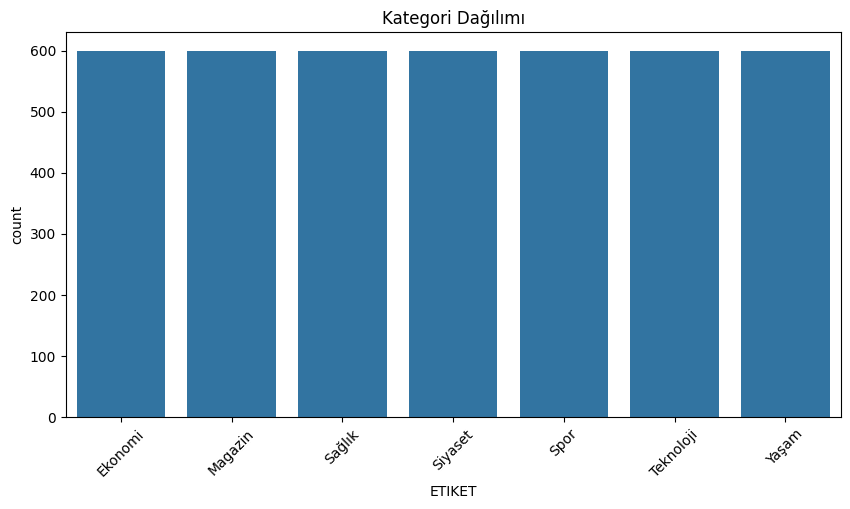

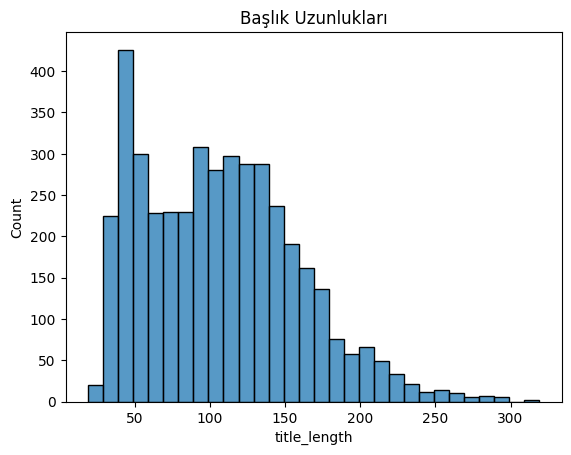

Eksik veri sayısı:
 HABERLER        0
ETIKET          0
title_length    0
dtype: int64


In [ ]:
# Kategori dağılımı
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='ETIKET')
plt.title("Kategori Dağılımı")
plt.xticks(rotation=45)
plt.show()

# Başlık uzunlukları
df['title_length'] = df['HABERLER'].apply(len)
sns.histplot(data=df, x='title_length', bins=30)
plt.title("Başlık Uzunlukları")
plt.show()

# Eksik veri
print("Eksik veri sayısı:\n", df.isnull().sum())

***4)VERİ ÖNİŞLEME***

In [ ]:
# VERİ ÖNİŞLEME
stop_words = set(stopwords.words('turkish'))
stemmer = TurkishStemmer()

def clean_text(text):
    if pd.isna(text):
        return ""

    # Küçük harfe çevirme (kısaltmaları koruyarak)
    words = text.split()
    processed_words = []

    for word in words:
        # Büyük harf kısaltmaları koru (TÜİK, THY, IMF vb.)
        if word.isupper() and len(word) > 1:
            processed_words.append(word)
        else:
            processed_words.append(word.lower())

    text = ' '.join(processed_words)

    # Kesme işareti ve ekleri temizle ÖNCE
    text = re.sub(r"'[a-zA-ZçğıöşüÇĞIİÖŞÜ]*", '', text)

    # Tek başına sayıları sil
    text = re.sub(r'\b\d+\b', '', text)

    # Finansal sembolleri ayır ve koru
    financial_symbols = re.findall(r'[$%€₺]', text)

    # Tüm noktalamayı sil
    text = re.sub(r'[^\w\s]', ' ', text)

    # Stopword'leri sil ve stemming uygula
    words = []
    for word in text.split():
        if word not in stop_words and len(word) > 2:
            # Kısaltmalar için stemming yapma
            if word.isupper():
                words.append(word)
            else:
                words.append(stemmer.stem(word))

    # Finansal sembolleri geri ekle
    result = ' '.join(words)
    if financial_symbols:
        result += ' ' + ' '.join(financial_symbols)

    return result

# Test
sample_text = "Enflasyon %8.5 arttı. TÜİK ve THY raporlarında %3 büyüme görüldü"
print("Önce:", sample_text)
print("Sonra:", clean_text(sample_text))

test_cases = [
    "TÜİK: 2023'te enflasyon %50'yi aştı!",
    "Fed faiz artırımı doları 18₺'ye çıkardı",
    "THY, 2023'te 75 milyon yolcu taşıdı",
    "Ekonomistler büyümenin devam edeceğini söylüyorlar"
]

for case in test_cases:
    print(f"\nÖnce: {case}")
    print(f"Sonra: {clean_text(case)}")

Önce: Enflasyon %8.5 arttı. TÜİK ve THY raporlarında %3 büyüme görüldü
Sonra: enflasyon artt TÜİK THY rapor büy görül % %

Önce: TÜİK: 2023'te enflasyon %50'yi aştı!
Sonra: TÜİK enflasyon aşt %

Önce: Fed faiz artırımı doları 18₺'ye çıkardı
Sonra: fed faiz artır dolar çıkar ₺

Önce: THY, 2023'te 75 milyon yolcu taşıdı
Sonra: THY milyon yolç taşı

Önce: Ekonomistler büyümenin devam edeceğini söylüyorlar
Sonra: ekonomist büyüme devam edecek söylüyor


In [ ]:
#veri temizleme
# Tüm başlıkları temizleme
df['cleaned_title'] = df['HABERLER'].apply(clean_text)

# Kategorileri sayısallaştırma
df['category_id'] = df['ETIKET'].factorize()[0]

# Temizlenmiş veriyi göster
df[['HABERLER', 'cleaned_title', 'ETIKET', 'category_id']].head()

,HABERLER,cleaned_title,ETIKET,category_id
0,TÜİK verilerine göre sanayi ciro endeksi Ağust...,TÜİK veri gör sanayi ciro endeks ağustos ayın ...,Ekonomi,0
1,Piyasa güne eksi rezervde başladı,piya gün eks rezerv başl,Ekonomi,0
2,"Citigroup, Deutsche Bank ve HSBC Libor manipül...",citigroup deutsche bank HSBC libor manipülasyo...,Ekonomi,0
3,Gelişen piyasa yatırımcılarını en fazla 'Fed' ...,gelişen piya yatırımcı fazl ilgilendiriyor,Ekonomi,0
4,Bitcoin fiyatında yükseliş hız kesmiyor,bitcoi fiyat yükseliş hız kesmiyor,Ekonomi,0


***5)TF-IDF vektörleri oluşturma***

In [ ]:
# TF-IDF vektörleri oluşturma
tfidf = TfidfVectorizer(
    max_features=10000,      # Özellik sayısını artır
    ngram_range=(1,3),       # 3-gram ekle
    min_df=2,                # Çok nadir kelimeleri çıkar
    max_df=0.8,              # Çok yaygın kelimeleri çıkar
    sublinear_tf=True        # TF normalleştirmesi
)
X = tfidf.fit_transform(df['cleaned_title'])
y = df['category_id']

# Eğitim ve test setleri
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

print("Eğitim seti boyutu:", X_train.shape)
print("Test seti boyutu:", X_test.shape)

Eğitim seti boyutu: (3570, 10000)
Test seti boyutu: (630, 10000)


## ***6)MODEL-1 NAİVE BAYES***

Naive Bayes Doğruluk: 0.9841269841269841

Sınıflandırma Raporu:
               precision    recall  f1-score   support

     Ekonomi       1.00      0.94      0.97        90
     Magazin       0.99      0.98      0.98        90
      Sağlık       0.98      0.99      0.98        90
     Siyaset       1.00      1.00      1.00        90
        Spor       0.99      1.00      0.99        90
   Teknoloji       0.94      0.99      0.96        90
       Yaşam       1.00      0.99      0.99        90

    accuracy                           0.98       630
   macro avg       0.98      0.98      0.98       630
weighted avg       0.98      0.98      0.98       630



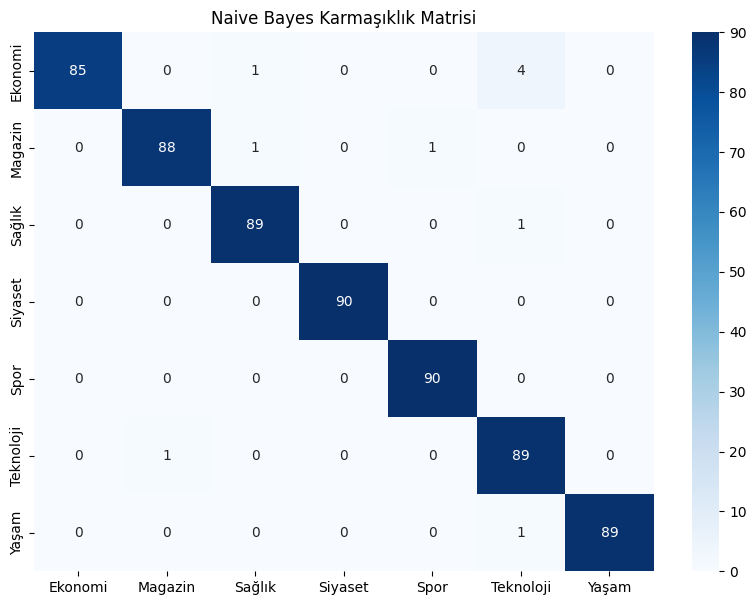

In [ ]:
# Naive Bayes modeli
nb_model = MultinomialNB(alpha=0.1)
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

# Performans metrikleri
print("Naive Bayes Doğruluk:", accuracy_score(y_test, y_pred_nb))
print("\nSınıflandırma Raporu:\n", classification_report(y_test, y_pred_nb, target_names=df['ETIKET'].unique()))

# Karmaşıklık matrisi
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt='d', cmap='Blues',
            xticklabels=df['ETIKET'].unique(),
            yticklabels=df['ETIKET'].unique())
plt.title("Naive Bayes Karmaşıklık Matrisi")
plt.show()

## ***7)MODEL-2 LOGİSTİC REGRESSİON***

Logistic Regression Doğruluk: 0.9793650793650793

Sınıflandırma Raporu:
               precision    recall  f1-score   support

     Ekonomi       0.97      0.94      0.96        90
     Magazin       0.99      0.97      0.98        90
      Sağlık       0.98      1.00      0.99        90
     Siyaset       0.99      0.98      0.98        90
        Spor       0.99      1.00      0.99        90
   Teknoloji       0.96      0.97      0.96        90
       Yaşam       0.99      1.00      0.99        90

    accuracy                           0.98       630
   macro avg       0.98      0.98      0.98       630
weighted avg       0.98      0.98      0.98       630



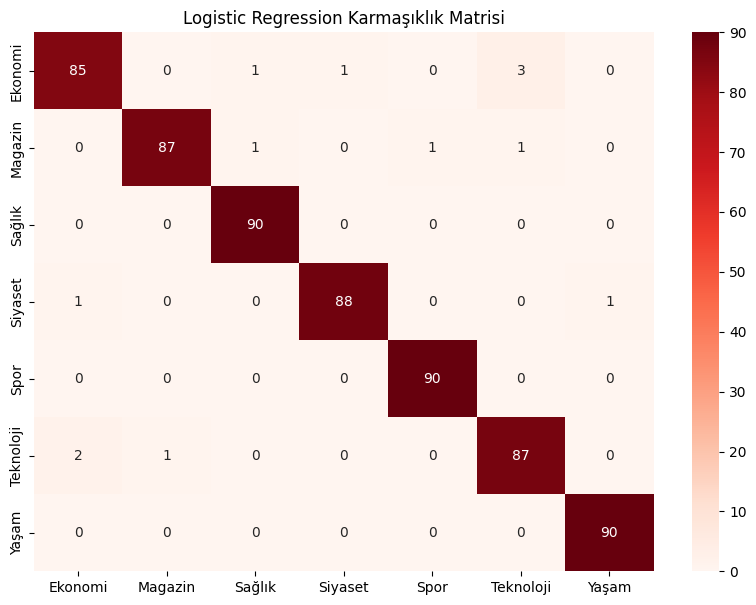

In [ ]:
# Logistic Regression modeli
lr_model = LogisticRegression(
    max_iter=1000,  # Yakınsama için iterasyon sayısı
    random_state=42
)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Performans metrikleri
print("Logistic Regression Doğruluk:", accuracy_score(y_test, y_pred_lr))
print("\nSınıflandırma Raporu:\n", classification_report(y_test, y_pred_lr, target_names=df['ETIKET'].unique()))

# Karmaşıklık matrisi
plt.figure(figsize=(10, 7))
sns.heatmap(
    confusion_matrix(y_test, y_pred_lr),
    annot=True,
    fmt='d',
    cmap='Reds',
    xticklabels=df['ETIKET'].unique(),
    yticklabels=df['ETIKET'].unique()
)
plt.title("Logistic Regression Karmaşıklık Matrisi")
plt.show()

8) MODELLERİN KARŞILAŞTIRILMASI

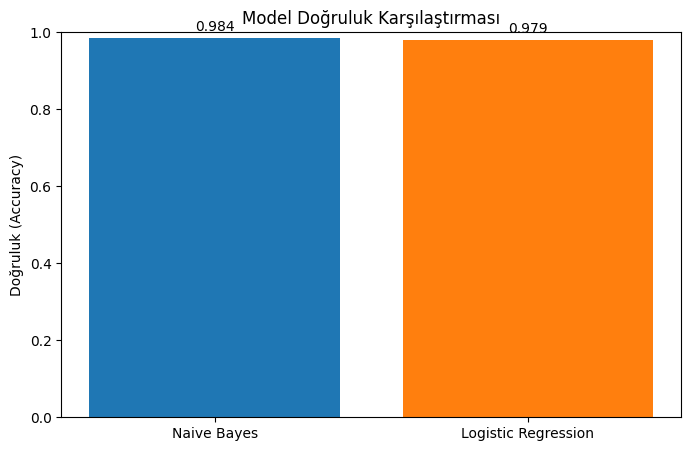

In [ ]:
# Modellerin doğruluk karşılaştırması
models = ['Naive Bayes', 'Logistic Regression']
accuracies = [accuracy_score(y_test, y_pred_nb), accuracy_score(y_test, y_pred_lr)]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=['#1f77b4', '#ff7f0e'])
plt.title("Model Doğruluk Karşılaştırması")
plt.ylabel("Doğruluk (Accuracy)")
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.3f}", ha='center')
plt.show()